## Spectrum
- [Joseph Fourier](https://cs.wikipedia.org/wiki/Joseph_Fourier)
- [Fourierova transformace](https://cs.wikipedia.org/wiki/Fourierova_transformace)

1.
- spočítejte plochu pod funkcí f(x) = 1 na intervalu 0 az 2

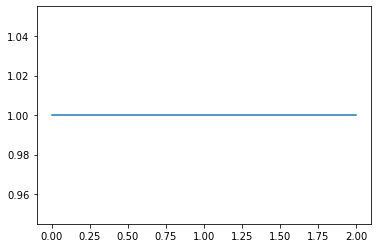

In [93]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2,10)
y = np.ones_like(x)

fig,ax = plt.subplots()
ax.plot(x,y)
plt.show()

np.trapz(y,x)

2.
- Načtěte soubor barnowl.txt z adresáře sova. V souboru jsou tzv. tuning curves měřené ve vlákně sluchového nervu. Tyto křivky reprezentují intenzitu signálu v závislosti na frekvenci, která byla nutná pro dosažení požadovaného výstupu (požadované nervové aktivity). Tyto křivky reflektují, že jednotlivá vlákna ve sluchovém nervu jsou nejlépe naladěna na určité frekvence. Pokud spočitáme inverzní křivky, získáme zhruba přenosovou charakateristiku pro dané vlákno.
- Spočítejte tzv. ekvivalentní čtvercovou šířku pásma. To jest, šířku pásma filtru s čtvercovou charakteristikou, který přenese stejný signál jako daný filtr.

802.2213640770017

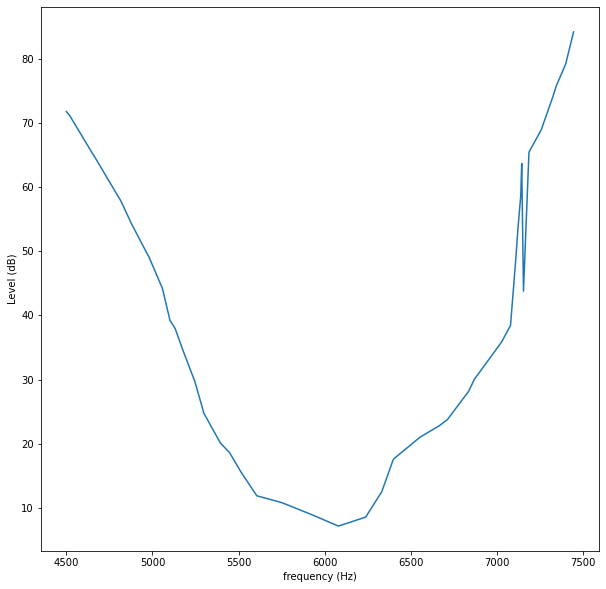

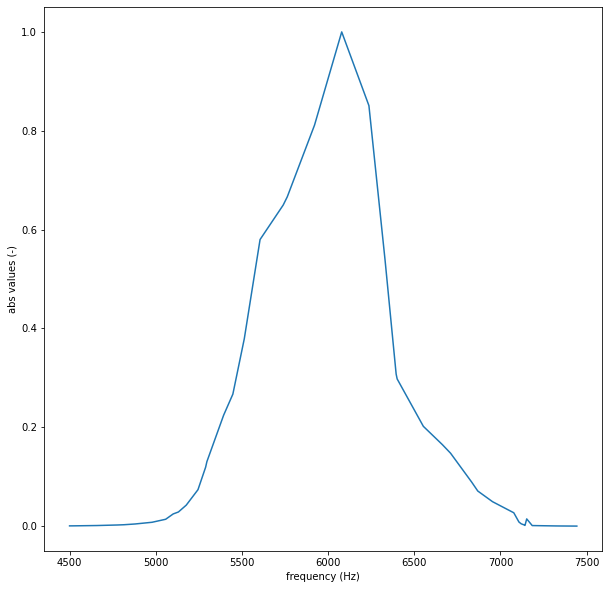

In [91]:
import numpy as np
data = np.loadtxt('sova/barnowl.txt')
fx = data[:,0]
TC = data[:,1]

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(fx,TC)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Level (dB)')


TClin = 10**(TC/20)  # convert from dB to 
TClin = np.min(TClin)/TClin

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(fx,TClin)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('abs values (-)')

np.trapz(TClin,fx)



In [90]:
x = np.linspace(0,2,100)
y = np.ones(len(x))

print(np.trapz(y,x))

2.0


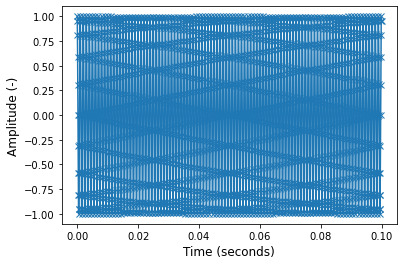

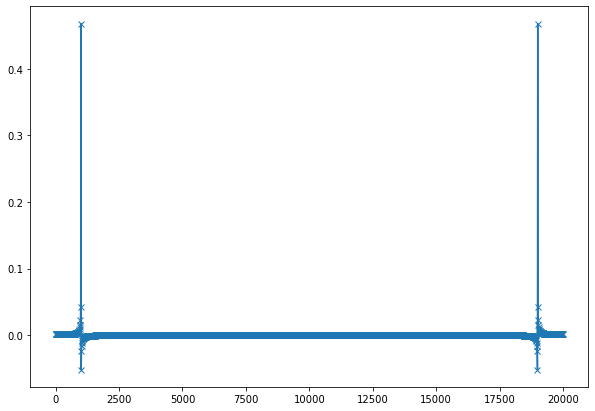

In [29]:
# generace tonu:
import numpy as np
import matplotlib.pyplot as plt

# vygenerovat sin(2pift)
T = 100e-3 # time 100 ms
fs = 20e3  # sampling frequency Hz
freq = 1001 # frequency in Hz

tx = np.linspace(0,T,int(T*fs),endpoint=False)
tone  = np.cos(2*np.pi*freq*tx)
fig,ax = plt.subplots()
ax.plot(tx,tone,'x-')
ax.set_xlabel('Time (seconds)',fontsize=12)
ax.set_ylabel('Amplitude (-)',fontsize=12)
plt.show()

# spocitat spektrum

S = np.fft.fft(tone)/len(tone)
fx = np.linspace(0,fs,len(tone),endpoint=False)  # frekvencni osa

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(fx,np.real(S),'x-')
#ax.plot(fx,np.imag(S),'x')
#ax.set_xlim([950,1050])
plt.show()





### Spontánní otoakustické emise (SOAE)

Akustické signály evokované ve vnitřním uchu bez specifické vnější akustické stimulace. To znamená, že tyto signály je možné nahrát mikrofonem vloženým do zvukovodu, aniž bychom ucho budili nějakým konkrétním signálem.

Podle jedné recenzované studie jsou SOAE přítomny u zhruba 70% normálně slyšících lidí. Kromě lidí jsou přítomny také u řady dalších obratlovců. Jejich frekvence je stabilní. Stejné hodnoty bychom nahráli u daného subjektu při opakovaném měření po jistém čase. Ale u malých dětí bývá největší výskyt emisí zhruba nad 3 kHz, kdežto u dospělých je to na frekvencích přibližně nad 1 kHz. Z toho lze usoudit, že se jejich frekvence s věkem může měnit.


<img src="./img/SOAEmereni.png" alt="soae" style="width: 500px;"/>

<img src="./img/SOAE.png" alt="soae" style="width: 500px;"/>


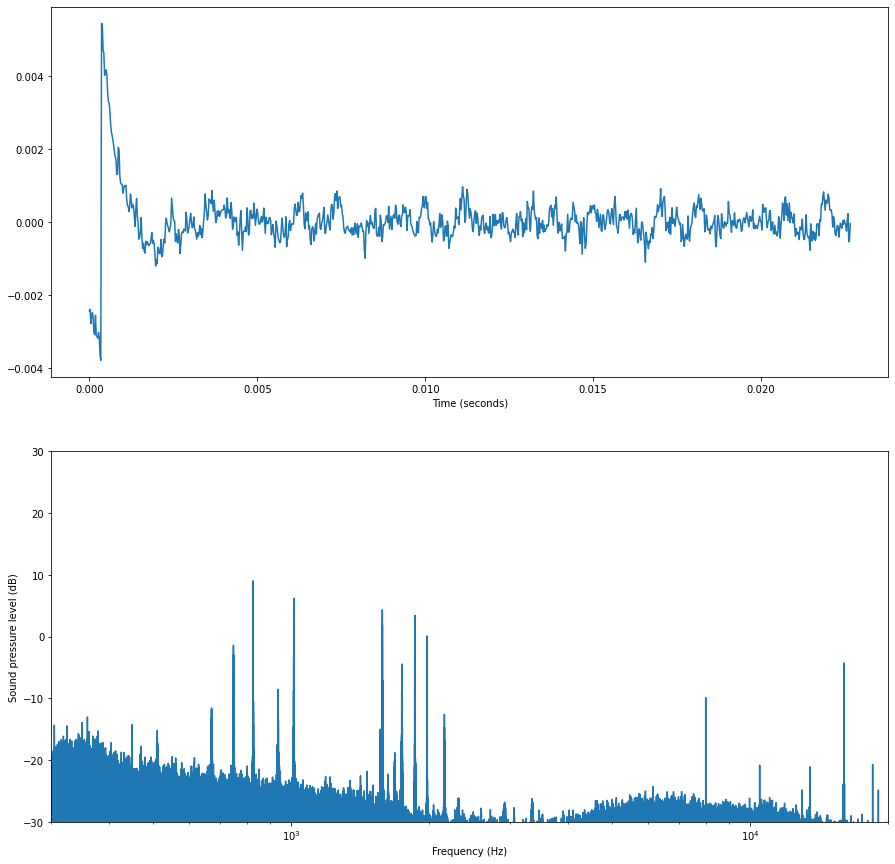

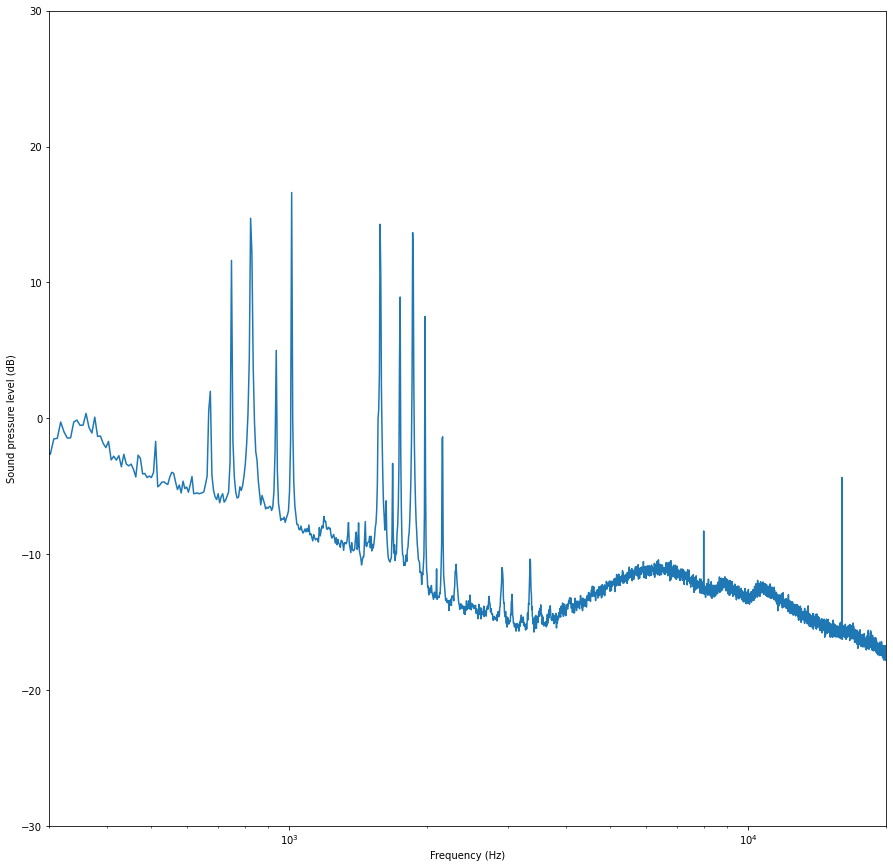

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read


def rfft(x):
    """calculates half of signal spectrum (assumed that signal is real)"""
    if x.ndim==1:  # check whether x is 1D
        N = int(np.ceil(len(x)/2)) # half of the spectrum
        xc = np.fft.fft(x)
        X = 2*xc[0:N]/len(x)  # take first half of the spectrum and normalize
    else:
        print('Input must be either a 1D array')
        X = None
    return X

fs, signal = read('SOAE/s015_soae_prave.wav')

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,15))
tx = np.arange(0,len(signal)/fs,1/fs)
ax1.plot(tx[:1000],signal[:1000])
ax1.set_xlabel('Time (seconds)')

S = rfft(signal)
pref = 20e-6 # sound pressure level
fx = np.linspace(0,fs/2,len(S),endpoint=False)
ax2.plot(fx,20*np.log10(np.abs(S)/pref))
ax2.set_xscale('log')
ax2.set_xlim([300, 20e3])
ax2.set_ylim([-30, 30])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Sound pressure level (dB)')

# spocitejte spektrum v okenku 8192 vzorku

Nw = 8192
Ns = len(data)//Nw*Nw
#sig_in_frames = np.reshape(signal,Nw)

Sp = np.zeros(int(Nw/2))
for i in range(len(signal)//Nw):
    Sp += np.abs(rfft(signal[i*Nw:(i+1)*Nw]))
    
Sp /= len(signal)//Nw
fxw = np.linspace(0,fs/2,len(Sp),endpoint=False)
fig,ax = plt.subplots(figsize=(15,15))
ax.plot(fxw,20*np.log10(Sp/2e-5))
ax.set_xscale('log')
ax.set_xlim([300, 20e3])
ax.set_ylim([-30, 30])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sound pressure level (dB)')
plt.show()

/tmp/ipykernel_1332473/2462320522.py:35: RuntimeWarning: overflow encountered in exp
  G = np.exp(T**2)
/tmp/ipykernel_1332473/2462320522.py:37: RuntimeWarning: overflow encountered in exp
  G = np.exp(G-1)
/tmp/ipykernel_1332473/2462320522.py:57: RuntimeWarning: divide by zero encountered in log10
  ax.plot(fx,20*np.log10(20*okno))


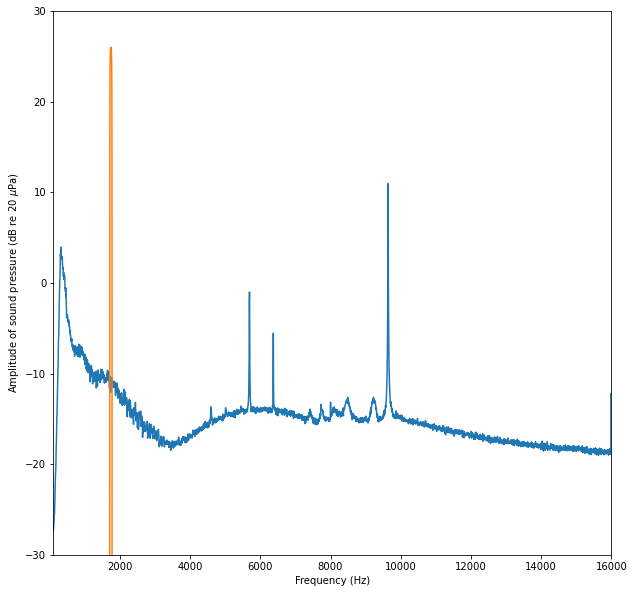

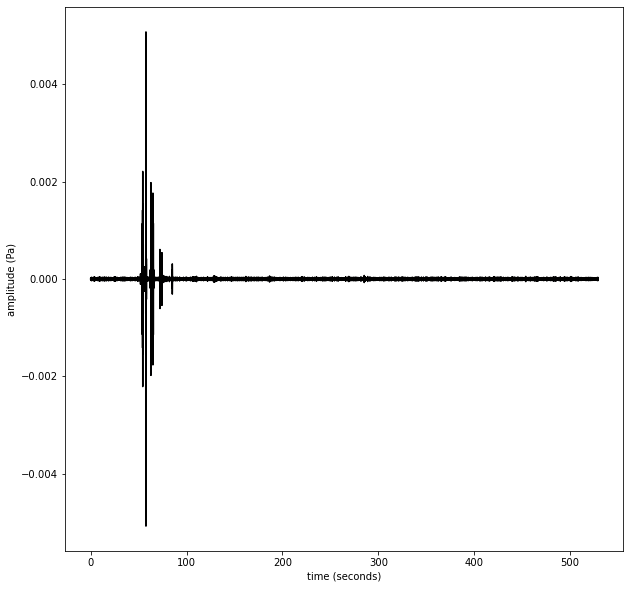

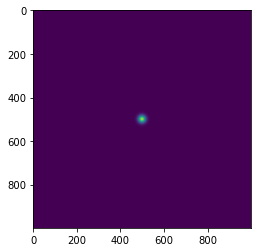

In [129]:
# dalsi zpracovani pro SOAE
# filtrace ve spektru, prevod zpet do casove domeny a vypocet obalky


CF = 1740  # center frequency filtru
BW = 60 # sirka pasma filtru


def irfft(X,nfft=None):
    """inversni Fourierova transformace pocitana z jedne poloviny spektra (pro kladne frekvence)"""
    if X.ndim == 1:
        nf = len(X)
        X[0] = np.real(X[0])
        X[nf-1] = np.real(X[nf-1])
        if nf%2:  # liche
            X = np.concatenate((X, np.conj(X[:0:-1])))  # conjugate and flip except the first sample X[0]
        else:   # sude
            X = np.concatenate((X, [np.conj(X[0])], np.conj(X[:0:-1])))
    else:
        print('Input must be 1D array')
        return None
    
    x = np.fft.ifft(X,nfft)
    
    x = np.real(x) + np.imag(x)
    return len(x)/2*x


def roex_in_freq(fx,fc,N=10):
    """vytvari rekursivni exponencialni okno"""
    g0 = 1
    for i in range(2,N+1):
        g0 = np.log(g0+1)
    T = np.sqrt(g0)*fx/fc
    G = np.exp(T**2)
    for i in range(2,N+1):
        G = np.exp(G-1)
    G = 1/G
    idx = np.where(fx>=1.2*fc)
    G = np.concatenate((G[idx[0][0]-1:0:-1],G[:idx[0][0]]))
    
    
    return G

# create a window

G = roex_in_freq(fx,BW/2)
# add zeros between 0 and begining of window
idx = np.where(fx>=CF)
nulypred = np.zeros(idx[0][0]-int(len(G)/2))
nulyvzad = np.zeros(len(fx)-len(nulypred)-len(G))
okno = np.concatenate((nulypred,G,nulyvzad))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(fxw[:len(Sp)],20*np.log10(Sp/(np.sqrt(2)*2e-5)))
ax.plot(fx,20*np.log10(20*okno))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude of sound pressure (dB re 20 $\mu$Pa)')
plt.xlim((100, 16000))
plt.ylim((-30, 30))

# nasob spektrum okenkem

vysek = S*okno[:len(S)]

tdsignal = irfft(vysek) # prevod zpet do casove domeny
# obalka


from scipy.signal import hilbert
# pocita obalku a vykresli ji
hv = hilbert(tdsignal)

tx = np.arange(0,len(tdsignal)/fs,1/fs)
               
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(tx,tdsignal,'b',lw=0.5,alpha=0.6)
ax.plot(tx,abs(hv),'k',tx,-abs(hv),'k',alpha=1)
ax.set_xlabel('time (seconds)')
ax.set_ylabel('amplitude (Pa)')




### EEG signal

- Příklad na EEG je převzat z Backyard Brains https://backyardbrains.com/experiments/quantifyyoureeg#prettyPhoto

- EEG signál byl nahrán pro

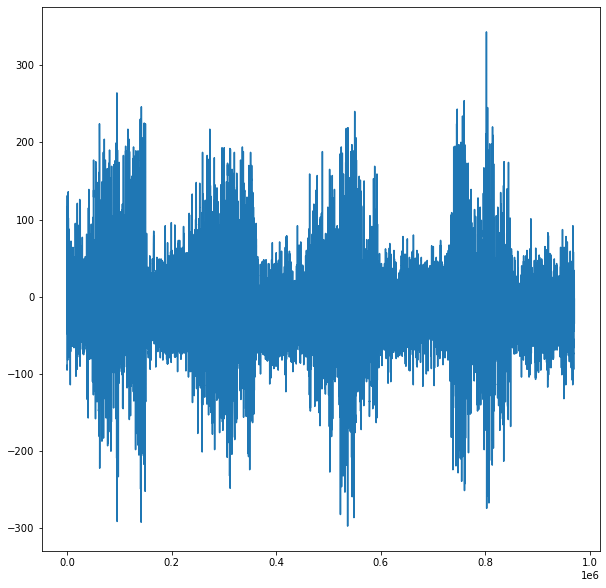

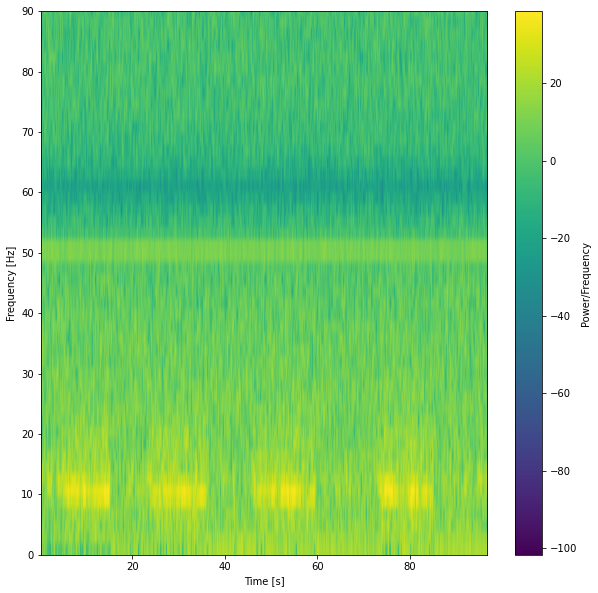

In [118]:
# eeg signal
# nacte signal z wav souboru, provede podvzorkovani (je to zejmena low frequency signal)
# zobrazi casovy prubeh a spektrogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

# load wav file

file = 'EEG_Alpha_SampleData/TimBrain_VisualCortex_BYB_Recording.wav'
fs, data = read(file)

plt.figure('eeg',figsize=(10,10))
plt.plot(data)

# resample 
length_data=np.shape(data)
length_new=length_data[0]*0.05
ld_int=int(length_new)
from scipy import signal
data_new=signal.resample(data,ld_int)

plt.figure('Spectrogram',figsize=(10,10))
d, f, t, im = plt.specgram(data_new, NFFT= 256, Fs=500, noverlap=250)
plt.ylim(0,90)
plt.colorbar(label= "Power/Frequency")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()


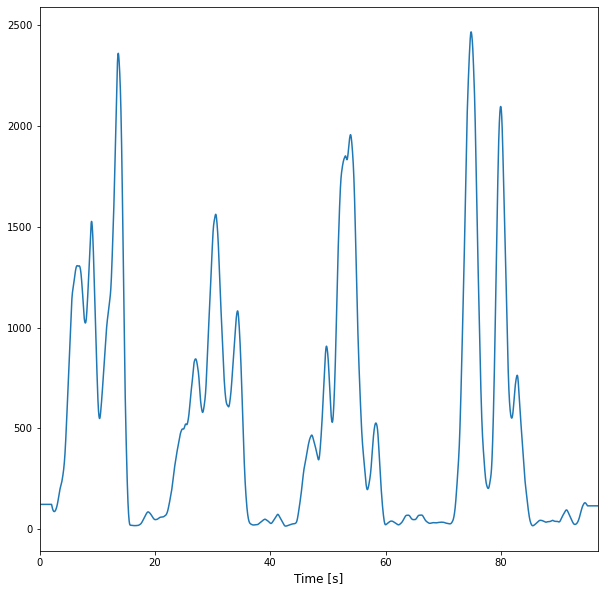

In [125]:
import csv
import pandas as pd

# ulozi vektor frekvenci do csv souboru
matrixf=np.array(f).T
np.savetxt('Frequencies.csv', matrixf)
df = pd.read_csv("Frequencies.csv", header=None, index_col=None)
df.columns = ["Frequencies"]
df.to_csv("Frequencies.csv", index=False)

# Pro vyber dat (frekvenci) se vytvori vektor s pozicemi (pro 7 Hz az 12 Hz).         

position_vector=[]
length_f=np.shape(f)
l_row_f=length_f[0]
for i in range(0, l_row_f):
    if f[i]>=7 and f[i]<=12:
        position_vector.append(i)

# spocita prumer hodnot spektra pro frekvence mezi 7 a 12 Hz
        
length_d=np.shape(d)
l_col_d=length_d[1]
AlphaRange=[]
for i in range(0,l_col_d):
    AlphaRange.append(np.mean(d[position_vector[0]:max(position_vector)+1,i]))


# data se pak vyhladi pomoci funkce:    
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed   


# vykresleni dat
plt.figure('AlphaRange',figsize=(10,10))
y=smoothTriangle(AlphaRange, 100)
plt.plot(t, y)
plt.xlabel('Time [s]',fontsize=12)
plt.xlim(0,max(t))
plt.show()